Max Profit Streak: 6 days
Average Profit Streak: 2.09 days
Std Dev of Profit Streak: 1.48
Max Drawdown (w.r.t FD): 1691


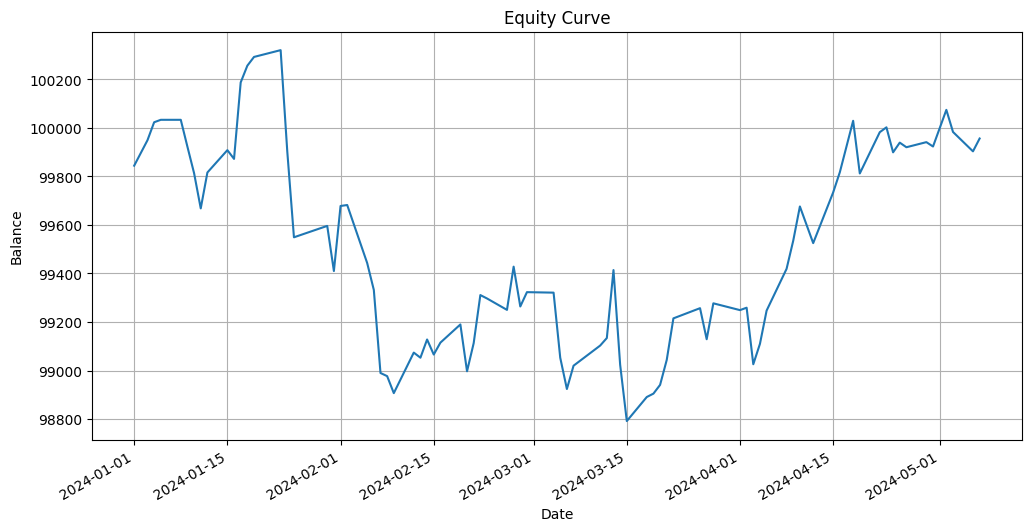

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set initial balance and fixed deposit rate
starting_balance = 100000
fixed_deposit_rate = 0.0001

# Load the CSV file containing daily PnL data
file_path = "daily_pnl.csv"
data = pd.read_csv(file_path, index_col=0, parse_dates=True, header=None)
data.columns = ['pnl']

# Calculate the balance over time
data['balance'] = starting_balance + data['pnl'].cumsum()

# Determine trading days (Monday to Friday) and calculate FD balance
data['trading_day'] = data.index.weekday < 5
data['fd_rate'] = np.where(data['trading_day'], fixed_deposit_rate, 0)
data['fd_balance'] = starting_balance * (1 + data['fd_rate']).cumprod()

# Calculate drawdown with respect to FD balance
data['fd_drawdown'] = 1 - data['balance'] / data['fd_balance'].cummax()

# Find maximum drawdown with respect to FD
max_fd_drawdown = data['fd_drawdown'].max() * 100

# Calculate daily PnL percentage
data['pnl_pct'] = data['pnl'] / starting_balance * 100

# Identify drawdown days where daily PnL < FD return
data['drawdown_fd'] = data['pnl_pct'] < data['fd_rate'] * 100

# Calculate profit streaks
data['profit_day'] = data['pnl'] > 0
profit_streak = (data['profit_day'].diff() != 0).cumsum()
profit_streak_counts = profit_streak[data['profit_day']].value_counts()
max_profit_streak = profit_streak_counts.max()
avg_profit_streak = profit_streak_counts.mean()
std_profit_streak = profit_streak_counts.std()
print(f"Max Profit Streak: {max_profit_streak} days")
print(f"Average Profit Streak: {avg_profit_streak:.2f} days")
print(f"Std Dev of Profit Streak: {std_profit_streak:.2f}")

# Calculate maximum drawdown and drawdown streak up to each day
data['max_dd'] = (data['fd_drawdown'].cummax() * starting_balance).round().astype(int)
data['dds'] = data['fd_drawdown'].gt(0).astype(int).groupby((data['fd_drawdown'].gt(0).astype(int) != data['fd_drawdown'].gt(0).astype(int).shift()).cumsum()).cumsum()

print(f"Max Drawdown (w.r.t FD): {data['max_dd'].max()}")

# Save the results to a CSV file
data[['pnl', 'max_dd', 'dds']].to_csv('output.csv')

# Format the output CSV file
output_data = pd.read_csv('output.csv', index_col=0)
output_data.index.name = 'date'
output_data.to_csv('formatted_output.csv')

# Plot the equity curve
fig, ax = plt.subplots(figsize=(12, 6))
data['balance'].plot(ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Balance')
ax.set_title('Equity Curve')
ax.grid(True)
plt.show()